# Test notebook
for porting collective radiance code to python

In [1]:
from numpy import *
import numpy.linalg as la
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from time import time
from random import random
import csv
from scipy.special import binom

# local 
from physconsts import *
from simfuncs import *

In [ ]:
### two level Rabi oscillation example

In [2]:
## simple Rabi oscillation in two level atom

psi0 = array([1,0], complex) # population starts in |g>

delta = 10
omega = 2*pi

# atom+field Hamiltonian, hbar=1
Haf = array([[0,-omega/2],[-omega/2,0]])

numsteps = 100
tmin = 0
tmax = 3 
tpts = linspace(tmin,tmax,numsteps)

dpsi = lambda t,state: 1j*dot(Haf,state)

soln = solve_ivp(dpsi,[tmin,tmax],psi0, t_eval=tpts,vectorized=True)

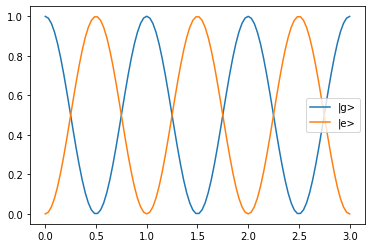

In [3]:
labels = ['|g>','|e>']
for i,y in enumerate(soln.y):
    plt.plot(soln.t,real(conjugate(y)*y),label=labels[i])
plt.legend(loc='best')

## reproduce single-excitation collective radiance results from my Mathematica code

In [4]:
# constants setup
lmbda = 7.8e-7
k = 2*pi/lmbda

# function definitions
unit = lambda v: array(v)/sqrt(dot(array(v),array(v)))
egen = eye(3) # generic basis set
ecart = [array([1,0,-1])/sqrt(2), 
         -1j*array([1,0,1])/sqrt(2), 
         array([0,1,0])]
matelem = ee*a0
gamma = matelem**2*k**3/(6*hbar*pi*e0)
quantum = (2*pi*c/lmbda)/gamma # energy in units gamma
gamma = 1 # gamma in units gamma

r = lambda i,j: array([0, 
                       mod(j,sqrt(atomnum)) - mod(i,sqrt(atomnum)),
                       floor(j/sqrt(atomnum)) - floor(i/sqrt(atomnum))])

def gdotp(r,p):
    """
    Dipole radiation measured at r
    
    Args:
        r: distance from dipole to measurement location
        p: vector representation of source dipole
    Returns:
        y: G acting on p, a complex vector
    """
    y = exp(1j*k*sqrt(dot(r,r)))*(cross(cross(unit(r),p),unit(r))
                                   + (1/(dot(r,r)*k**2)  
                                   - 1j/(k*sqrt(dot(r,r)))) \
                                   *(3*unit(r)*dot(unit(r),p) - p)) \
                                 /(4*pi*sqrt(dot(r,r)))
    return y

def prod_state(states, thresh):
    """
    Compute the product state for an aggregrate quantum system
    
    Args:
        states: list of equal-length arrays where each array stores
            the amplitudes describing the state of an individual system.
        thresh: the minimum acceptible probability of measuring a given
            basis vector in the product space. all basis vectors with
            amplitudes c where abs(c) < sqrt(thresh) will be omitted from
            the product space, giving an approximate basis for the state.
    Return:
        pstate:
            the approximate product state vector
    """
    pstate = states[0]
    for i in range(1, len(states)):
        pstate = array([p for p in kron(pstate, states[i]) if abs(p) > sqrt(thresh)])
    return pstate

class ArrayMode:
    
    def __init__(self, vector, name, color):
        self.vector = vector
        self.name = name
        self.color = color
        
    def __repr__(self):
        return f"ArrayMode({self.name})"

### linewidth v period

In [27]:
# square grid setup
atomnum = 400
gridname = "square"
fmode = ArrayMode(unit(full(atomnum,1)), 'Symmetric', 'blue')
afmode = ArrayMode(unit([(-1)**(i+1) for i in range(atomnum)]), 'Asymmetric', 'purple')
modelist = [fmode, afmode]

basisnum = atomnum

In [38]:
# build the hamiltonian

unitp = egen[0] # atom polarization
dsteps = linspace(0.01,1.0,20)
soln = empty((len(modelist),len(dsteps)),float)

t0 = time()
for d_idx,d in enumerate(dsteps):
    hamiltonian = empty((basisnum, basisnum), complex)
    
    # build the hamiltonian

    for i in range(basisnum):
        for j in range(basisnum):
            if i!=j:
                u = lmbda*d*r(i,j)
                hamiltonian[i,j] = 6*pi*gamma*dot(unitp, gdotp(u, unitp))/k
            else:
                hamiltonian[i,j] = 1j*gamma
    
    # find eigenmodes that overlap target mode
    evals,evecs = la.eig(hamiltonian)
    for m_idx,mode in enumerate(modelist):
        overlap = [[] for i in range(basisnum)]
        for i in range(basisnum):
            overlap[i] = [i,abs(dot(mode.vector, evecs[:,i]))]
        overlap.sort(key=lambda x: x[1]) # sort by overlap
        max_idx = overlap[-1][0]
        soln[m_idx,d_idx] = imag(evals[max_idx])/gamma

        
    print(f"calculated step {d_idx}")

print(f"sim ran for {floor((time()-t0)/60)} minutes")

calculated step 0
calculated step 1
calculated step 2
calculated step 3
calculated step 4
calculated step 5
calculated step 6
calculated step 7
calculated step 8
calculated step 9
calculated step 10
calculated step 11
calculated step 12
calculated step 13
calculated step 14
calculated step 15
calculated step 16
calculated step 17
calculated step 18
calculated step 19
sim ran for 8.0 minutes


'plot_linewidth_v_period_20x20_square.png'

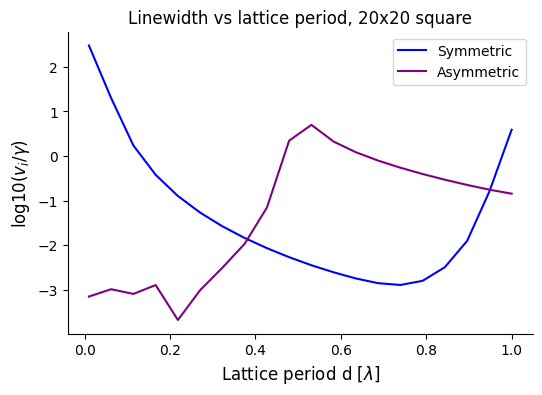

In [39]:
fig,ax = plt.subplots(dpi=100)
for s,m in zip(soln,modelist):
    ax.plot(dsteps,log10(s),label=m.name,c=m.color)
ax.set_title(f'Linewidth vs lattice period, {int(sqrt(atomnum))}x{int(sqrt(atomnum))} square')
ax.set_xlabel(r"Lattice period d [$\lambda$]",fontsize=12)
ax.set_ylabel(r"log10($v_i/\gamma$)",fontsize=12)
for spine in ['right','top']:
    ax.spines[spine].set_visible(False)
ax.legend()

fname = f'plot_linewidth_v_period_{int(sqrt(atomnum))}x{int(sqrt(atomnum))}_{gridname}.png'
plt.savefig(fname, bbox_inches='tight')
fname

In [40]:
# test write soln to csv
data = [dsteps] + [s for s in soln]
labels = ['d [lambda]'] + [m.name for m in modelist]

fname = fname.replace('plot','soln')
fname = fname.replace('png','csv')
soln_to_csv(fname, data, labels)

wrote data to soln_linewidth_v_period_20x20_square.csv


In [9]:
# test retrieve soln from csv
data, labels = soln_from_csv('testfun1.csv')
xsteps = data[0]
soln = data[1:]

xlabel = labels[0]
ylabels = labels[1:]

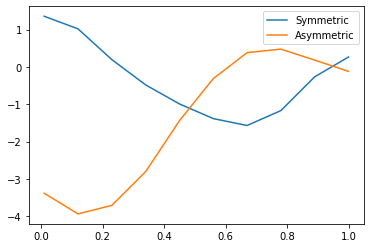

In [12]:
# plot the soln to verify it was stored and retrieved correctly
fig,ax = plt.subplots()
for s,l in zip(soln,ylabels):
    ax.plot(real(xsteps),log10(real(s)),label=l)
ax.legend()

### time evolution: single excitation states

In [98]:
# square grid setup
atomnum = 25
gridname = "square"
fmode = ArrayMode(unit(full(atomnum,1,complex)), 'Symmetric', 'blue')
afmode = ArrayMode(unit(array([(-1)**(i+1) for i in range(atomnum)],complex)), 'Asymmetric', 'purple')
modelist = [fmode, afmode]
center_idx = int(floor(sqrt(atomnum)/2)*(sqrt(atomnum)+1))

basisnum = atomnum

In [99]:
## params
unitp = egen[0] # atom polarization
d = 0.75
tmin = 0 
tmax = 100
numsteps = 100
tsteps = linspace(tmin, tmax, numsteps)
moi = fmode # mode of interest

## setup initial state
exc_idcs = array([[center_idx+i+j for i in [-sqrt(atomnum), 0, sqrt(atomnum)]]
       for j in [-1,0,1]],int).flatten()
psi0 = full(atomnum, 0, complex)
psi0[exc_idcs] = 1/3
soln = empty(len(tsteps),float)

## build the hamiltonian
hamiltonian = empty((basisnum, basisnum), complex)
for i in range(basisnum):
    for j in range(basisnum):
        if i!=j:
            u = lmbda*d*r(i,j)
            hamiltonian[i,j] = 6*pi*gamma*dot(unitp, gdotp(u, unitp))/k
        else:
            hamiltonian[i,j] = 1j*gamma
            
evals,evecs = la.eig(hamiltonian)

## find the mode of interest
overlap = [[i,abs(dot(moi.vector, evecs[:,i]))] for i in range(basisnum)]
overlap.sort(key=lambda x: x[1]) # sort by overlap
max_idx = overlap[-1][0]
tmode = ArrayMode(evecs[:,max_idx],moi.name,moi.color)
            
## setup and solve Schrodinger eq
dpsi = lambda t,state: 1j*dot(hamiltonian,state)

t0 = time()
soln = solve_ivp(dpsi,[tmin,tmax],psi0,t_eval=tsteps,vectorized=True)#,
                 #rtol=1e-12,atol=1e-12,method='BDF')

## transform to vector solution
vecsoln = soln.y.T

print(f"sim ran for {floor((time()-t0)/60)} minutes")

sim ran for 0.0 minutes


In [100]:
amax(hamiltonian)

(0.1916604805627975+0.11318953271386076j)

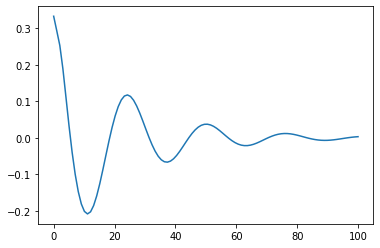

In [16]:
plt.plot(soln.t, real(soln.y[center_idx]))

In [17]:
# test write vector solution to file
soln_to_csv('test_vec.csv', vecsoln, tsteps)

wrote data to test_vec.csv


In [18]:
# test retrieval of vector solution from file
vecsoln,stepstrs = soln_from_csv('test_vec.csv')

In [19]:
modesoln = empty(numsteps, float) # population in mode of interest
totalsoln = empty(numsteps, float) # total population

norm = sum([abs(dot(evec,vecsoln[0]))**2 for evec in evecs.T])

for i in range(numsteps):
    # find overlap with mode of interest
    modesoln[i] = abs(dot(vecsoln[i], tmode.vector))**2/norm
    totalsoln[i] = sum([abs(dot(vecsoln[i], evec))**2 for evec in evecs.T])/norm
    
othersoln = totalsoln - modesoln # pop. in non-interesting modes
solnlist = [modesoln,totalsoln,othersoln]
ylabels = [moi.name, 'total', 'other']

In [20]:
abs(dot(vecsoln[0],tmode.vector))**2

0.7501655815179968

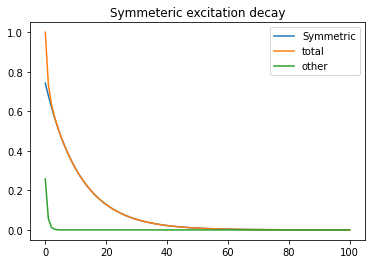

In [21]:
fig,ax = plt.subplots()

for s,l in zip(solnlist, ylabels):
    ax.plot(tsteps,s,label=l)
    
ax.set_title('Symmeteric excitation decay')
ax.legend()

In [22]:
# test write soln to csv
data = [tsteps] + [s for s in solnlist]
labels = ['t [gamma]'] + [l for l in ylabels]
num = int(sqrt(atomnum))
fname = f'soln_decay_{moi.name.lower()}_{num}x{num}_{gridname}.csv'
soln_to_csv(fname, data, labels)

wrote data to soln_decay_symmetric_5x5_square.csv


In [16]:
# test retrieve soln from csv
fname = 'soln_decay_symmetric_5x5_square.csv'
data, labels = soln_from_csv(fname)
xsteps = data[0]
ydata = data[1:]

xlabel = labels[0]
ylabels = labels[1:]

In [17]:
labels

['t [gamma]', 'Symmetric', 'total', 'other']

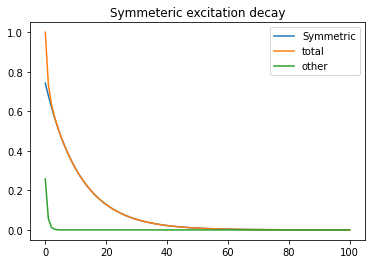

In [18]:
fig,ax = plt.subplots()

for s,l in zip(ydata, ylabels):
    ax.plot(real(xsteps),real(s),label=l)
    
ax.set_title('Symmeteric excitation decay')
ax.legend()

### time evolution: product state

In [101]:
## basis setup
atomnum = 25
excitations = 2 # highest number of excitations
one_atoms = range(atomnum)
two_atoms = []
for i in range(atomnum):
    for j in range(i):
        two_atoms.append(array([i,j]))
atom_states = list(one_atoms) + two_atoms
basisnum = len(atom_states)

In [102]:
## square grid setup
gridname = "square"
center_idx = int(floor(sqrt(atomnum)/2)*(sqrt(atomnum)+1))

## sym. mode
fmode = ArrayMode(unit(concatenate((full(atomnum,1,complex),
                                   zeros(basisnum-atomnum)))), 'Symmetric', 'blue')

## product state
beta = 1/sqrt(atomnum)
alpha = sqrt(1-beta**2)
pvec = prod_state([array([alpha, beta],complex) for j in range(atomnum)],1e-4)[1:]
assert basisnum == len(pvec)

# sort. not always sensible choice, but valid for ordering into 1-,2- excitation kets
pvec.sort()
pvec = flip(pvec)
print(f"{len(pvec)} basis states in product state approximation")
pmode = ArrayMode(pvec, "Product", 'green')

325 basis states in product state approximation


In [103]:
## params
unitp = egen[0] # atom polarization
d = 0.75
tmin = 0 
tmax = 100
numsteps = 100
tsteps = linspace(tmin, tmax, numsteps)
moi = pmode # mode of interest

## setup initial state
# exc_idcs = array([[center_idx+i+j for i in [-sqrt(atomnum), 0, sqrt(atomnum)]]
#        for j in [-1,0,1]],int).flatten()
# psi0 = full(basisnum, 0, complex)
# psi0[exc_idcs] = 1/3

psi0 = pmode.vector
soln = empty(len(tsteps),float)

In [187]:
## build the hamiltonian
t0 = time()
omega = (2*pi*c/lmbda)/1e6 # 
print("constructing hamiltonian...")
hamiltonian = empty((basisnum, basisnum), complex)
for i in range(atomnum):
    for j in range(atomnum):
        if i!=j:
            u = lmbda*d*r(i,j)
            hamiltonian[i,j] = 6*pi*gamma*dot(unitp, gdotp(u, unitp))/k
        else:
            hamiltonian[i,j] = 1j*gamma
for i in range(atomnum, basisnum):
    for j in range(atomnum, basisnum):
        if i!=j:
            atomsi = atom_states[i]
            atomsj = atom_states[j]
            inter = intersect1d(atomsi,atomsj)
            if len(inter) == 1:
                pair = [atom for atom in concatenate((atomsi,atomsj)) \
                        if atom not in inter]
                u = lmbda*d*r(*pair)
            hamiltonian[i,j] = 6*pi*gamma*dot(unitp, gdotp(u, unitp))/k
        else:
            hamiltonian[i,j] = -10 + 1j*gamma
print(f"constructed hamiltonian in {int(floor((time()-t0)/60))} minutes")

assert hamiltonian.shape == (basisnum,basisnum)

t0 = time()
print("diagonalizing hamiltonian...")
evals,evecs = la.eig(hamiltonian)
print(f"diagonalized hamiltonian in {int(floor((time()-t0)/60))} minutes")

constructing hamiltonian...
constructed hamiltonian in 0 minutes
diagonalizing hamiltonian...
diagonalized hamiltonian in 0 minutes


In [ ]:
## find the mode of interest (optional)
overlap = [[i,abs(dot(moi.vector, evecs[:,i]))] for i in range(basisnum)]
overlap.sort(key=lambda x: x[1]) # sort by overlap
max_idx = overlap[-1][0]

In [130]:
tmode = ArrayMode(evecs[:,max_idx],moi.name,moi.color)

In [191]:
## set up and solve time evolution - try solving in chunks to debug
dpsi = lambda t,state: 1j*dot(hamiltonian,state)
stop = 5
t0 = time()
print("solving Schrodinger equation...let the cat evolve")
soln = solve_ivp(dpsi,[tmin,tsteps[stop]],psi0,t_eval=tsteps[:stop],vectorized=True,method='BDF')
print("done. time to check the cat.")
print(f"sim ran for {int(floor((time()-t0)/60))} minutes")

# transform to vector solution
vecsoln = soln.y.T

solving Schrodinger equation...let the cat evolve
done. time to check the cat.
sim ran for 0 minutes


In [192]:
numsteps = len(vecsoln)
modesoln = empty(numsteps, float) # population in mode of interest
totalsoln = empty(numsteps, float) # total population

norm = sum([abs(dot(evec,vecsoln[0]))**2 for evec in evecs.T])

for i in range(numsteps):
    # find overlap with mode of interest
    modesoln[i] = abs(dot(vecsoln[i], tmode.vector))**2/norm
    totalsoln[i] = sum([abs(dot(vecsoln[i], evec))**2 for evec in evecs.T])/norm
    
othersoln = totalsoln - modesoln # pop. in non-interesting modes
solnlist = [modesoln,totalsoln,othersoln]
ylabels = [moi.name, 'total', 'other']

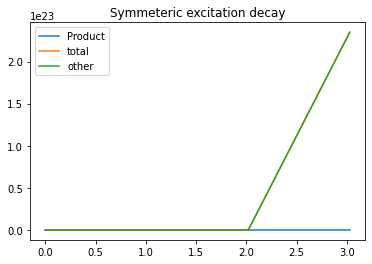

In [193]:
stop = -1
fig,ax = plt.subplots()
for s,l in zip(solnlist, ylabels):
    ax.plot(soln.t[:stop],s[:stop],label=l)
    
ax.set_title('Symmeteric excitation decay')
ax.legend()

In [150]:
len(soln.t)

14513

In [43]:
# retrieve of vector solution from file
fname = 'soln_prod_decay_5x5_grid_20201129_16_53_58.csv'
vecsoln,stepstrs = soln_from_csv(fname)
tsteps = array([float(s) for s in stepstrs])
numsteps = len(tsteps)

In [44]:
moi = tmode = pmode

In [45]:
modesoln = empty(numsteps, float) # population in mode of interest
totalsoln = empty(numsteps, float) # total population

norm = sum([abs(dot(evec,vecsoln[0]))**2 for evec in evecs.T])

for i in range(numsteps):
    # find overlap with mode of interest
    modesoln[i] = abs(dot(vecsoln[i], tmode.vector))**2/norm
    totalsoln[i] = sum([abs(dot(vecsoln[i], evec))**2 for evec in evecs.T])/norm
    
othersoln = totalsoln - modesoln # pop. in non-interesting modes
solnlist = [modesoln,totalsoln,othersoln]
ylabels = [moi.name, 'total', 'other']

<ipython-input-45-e1f03067b7d5>:8: RuntimeWarning: overflow encountered in double_scalars
  modesoln[i] = abs(dot(vecsoln[i], tmode.vector))**2/norm
<ipython-input-45-e1f03067b7d5>:9: RuntimeWarning: overflow encountered in double_scalars
  totalsoln[i] = sum([abs(dot(vecsoln[i], evec))**2 for evec in evecs.T])/norm
<ipython-input-45-e1f03067b7d5>:11: RuntimeWarning: invalid value encountered in subtract
  othersoln = totalsoln - modesoln # pop. in non-interesting modes


In [46]:
abs(dot(vecsoln[0],tmode.vector))**2

0.31710398809091356

In [47]:
len(solnlist[1])

79

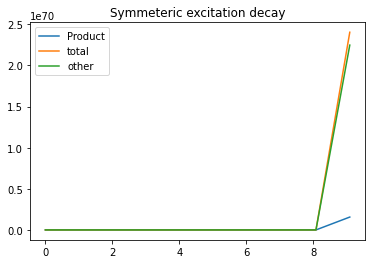

In [49]:
fig,ax = plt.subplots()
stop = 10
for s,l in zip(solnlist, ylabels):
    ax.plot(tsteps[:stop],s[:stop],label=l)
    
ax.set_title('Symmeteric excitation decay')
ax.legend()